#  <center> Taller  de Aprendizaje Automático </center>
##  <center> PROYECTO 2: Freesound Audio Tagging 2019  </center>
###  <center> Grupo C  </center>

In [2]:
#!pip install comet_ml
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install pandas
# !pip install pydub
# !pip install wave
!pip install scipy
!pip install kapre


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl.metadata (2.7 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl.metadata (14 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metada

In [2]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import pandas as pd
import shutil
import wave
from IPython.display import Audio
from scipy.io import wavfile
from scipy.signal import resample
from tensorflow.keras.models import Sequential
import pydub
from pydub.silence import split_on_silence
from pydub import AudioSegment, effects 
from scipy.io.wavfile import read, write
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from comet_ml import Experiment
from tensorflow.keras.models import load_model # model = load_model("modelo_final.keras", custom_objects={'LWLRAP': LWLRAP})
import kapre
from spec_augment import SpecAugment


C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


PARA USAR CON COLLAB!!

In [ ]:
# Detected corrupted files in the curated train set
# The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process:
# f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav

# The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.

In [ ]:
# import lwlrap_share # me trae las funciones? probar!

# Carga de datos

In [4]:
# df_train_curados = pd.read_csv('train_curated.csv')
# df_train_ruidosos = pd.read_csv('train_noisy.csv')

df_train_curados = pd.read_csv('train_curated.csv')
df_train_ruidosos = pd.read_csv('train_noisy.csv')

#df_test = pd.read_csv('taa-2025-freesound-audio-tagging/sample_submission.csv')



# Conjunto de train y val

In [5]:
# esta comentado porque luego uso función que arma ya los conjuntos a partir del df (en modelos!)

df_train, df_val = train_test_split(df_train_curados, test_size=0.2, random_state=42, shuffle=True, stratify=None)

# print(df_train.shape)
# print(df_val.shape)
# # revisar con histograma distribución de etiquetas

# Funciones de preprocesamiento

## De carpetas

In [6]:
# sacar de train curated las que no son tan curated

# https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe

def limpiando_train_curated(df_curados,df_ruidosos):
    ex_curados = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav']
    df_ex_curados = df_curados[df_curados['fname'].isin(ex_curados)] # valores a concatenar
    indices_a_dropear = df_curados[df_curados['fname'].isin(ex_curados)].index # indices a dropear
    # defino nuevos df
    df_curados_posta = df_curados.drop(indices_a_dropear, axis=0) # saco de curados
    df_ruidosos_posta = pd.concat(df_ruidosos,df_ex_curados) # agrego a ruidosos
    return df_curados_posta, df_ruidosos_posta


Armamos siempre primero sin silencios y luego resampleado! Ojo con eso

In [ ]:
# def resampleo(ruta_audio,nombre,path_salida):
#     rate, audio = read(ruta_audio)
#     origin_num_samples = len(audio)
#     new_samps = int(origin_num_samples * 16000/rate)

#     # resampling
#     target_audio_scipy = resample(audio, new_samps).astype(int)
#     target_audio_scipy = np.array(target_audio_scipy, np.int16)

#     ruta_audio_salida = path_salida + nombre # evaluar nombre y si lo guardamos en la misma carpeta

#     write(ruta_audio_salida,16000,target_audio_scipy)
#     return target_audio_scipy

In [18]:
# # PARA ARMAR CARPETA CON CURADOS RESAMPLEADOS

# ruta_curada_sin_silencios = 'train_curated/' # uri y elias cambiar
# path_salida = "resampleo/"

# for i in range(np.shape(df_train_curados)[0]):
#     nombre = df_train_curados['fname'][i]
#     print(nombre)
#     ruta_audio = ruta_curada_sin_silencios+nombre
#     resampleo(ruta_audio, nombre, path_salida)

#     # 4 minutos

In [4]:
# # PARA ARMAR CARPETA CON RUIDOSOS RESAMPLEADOS

# ruta_curada_sin_silencios = 'train_ruidosos_sin_silencios_2/' # uri y elias cambiar
# path_salida = "train_ruidosos_sin_silencios_resample/"

# for i in range(np.shape(df_train_ruidosos)[0]):
#     nombre = df_train_ruidosos['fname'][i]
#     print(nombre)
#     ruta_audio = ruta_curada_sin_silencios+nombre
#     resampleo(ruta_audio, nombre, path_salida)

#     # 22 minutos

In [3]:
# # # PARA ARMAR CARPETA CON TEST RESAMPLEADOS

# ruta_test_sin_silencios = 'test_sin_silencios/' # uri y elias cambiar
# path_salida = "test_sin_silencios_resample/"

# for i in range(np.shape(df_test)[0]):
#     nombre = df_test['fname'][i]
#     print(nombre)
#     ruta_audio = ruta_test_sin_silencios+nombre
#     resampleo(ruta_audio, nombre, path_salida)

#     # 3 minutos

In [7]:
# sacar silencios
# https://onkar-patil.medium.com/how-to-remove-silence-from-an-audio-using-python-50fd2c00557d <- referenciar si lo usamos!

def sacar_silencios(ruta_audio, nombre,path_salida, largo_optimo = 1000):
    ''''
    ruta_audio: ruta del audio a recortar
    largo_optimo: largo en mili segundos a considerar
    '''

    rate, audio = read(ruta_audio)

    largo_audio = len(audio)/rate *1000

    largo = min(largo_optimo,largo_audio)

    # make the audio in pydub audio segment format
    aud = AudioSegment(audio.tobytes(),frame_rate = rate,
                        sample_width = audio.dtype.itemsize,channels = 1)
    # use split on sience method to split the audio based on the silence, 
    # here we can pass the min_silence_len as silent length threshold in ms and intensity thershold
    audio_chunks = split_on_silence(
        aud,
        # min_silence_len = int(largo/10), # evaluar si 1/4 del largo optimo esta ok o no. a lo mejor
        # silence_thresh = -45, # umbral de silencio.. averiguar ruidos tipicos
        # keep_silence = largo/100,) # o menos? ver que sea en funcion del largo del audio 
        
        # PRUEBA CON OTROS PARAMETROS A VER SI SE REDUCEN MÁS O MENOS
        min_silence_len=300,
        silence_thresh=-40,
        keep_silence=100)

    #audio chunks are combined here

    # esto es para cuando todo es detectado como silencio
    if len(audio_chunks) == 0:
        audio_chunks = [aud]
    audio_processed = sum(audio_chunks)
    audio_processed = np.array(audio_processed.get_array_of_samples())

    # sin_extension, extension = os.path.splitext(ruta_audio)

    # ruta_audio_salida = path_salida + nombre + '_sin_silencio' # evaluar nombre y si lo guardamos en la misma carpeta
    ruta_audio_salida = path_salida + nombre # evaluar nombre y si lo guardamos en la misma carpeta

    write(ruta_audio_salida,rate,audio_processed)

In [ ]:
# # PARA ARMAR CARPETA SIN SILENCIOS CURADA (resampleados de los profesores)

# ruta_curada = 'taa-2025-freesound-audio-tagging/train_curated_resampled/train_curated_resampled/' # uri y elias cambiar
# path_salida = 'train_curated_sin_silencios_resample/'

# for i in range(np.shape(df_train_curados)[0]):
#      nombre = df_train_curados['fname'][i]
#      print(nombre)
#      ruta_audio = ruta_curada+nombre
#      sacar_silencios(ruta_audio, nombre, path_salida)

#      # 6 minutos

0006ae4e.wav
0019ef41.wav
001ec0ad.wav
0026c7cb.wav
0026f116.wav
003be5db.wav
0041de6b.wav
004ca909.wav
00713ec2.wav
0073825a.wav
00975c2a.wav
009ca29f.wav
00b0b76f.wav
00c17dd2.wav
00c40a6d.wav
00c4e82c.wav
00c7ff40.wav
00c91dfc.wav
00ffa0d2.wav
0110ba24.wav
012c15b5.wav
013b01b9.wav
01565c33.wav
015a50b9.wav
0164cba5.wav
0175a379.wav
019234bc.wav
0199c0a0.wav
01a5de85.wav
02171503.wav
0217540b.wav
02286d70.wav
02356bfd.wav
023935e1.wav
02430fbe.wav
024e0fbe.wav
02633663.wav
027ab7f6.wav
028ddadb.wav
029adfea.wav
029bd777.wav
029c1c70.wav
02a25949.wav
02a5aae7.wav
02abea37.wav
02c55707.wav
02c86123.wav
02ddd8da.wav
02e3dbfe.wav
02f54ef1.wav
02fb5725.wav
030d5b55.wav
03106a7c.wav
0331a1bb.wav
035d21e0.wav
03730245.wav
037b9243.wav
03815f4c.wav
038296b8.wav
038af178.wav
03bafda9.wav
03d241c1.wav
03e47a59.wav
03e77f6b.wav
03ea2668.wav
03f48534.wav
03f91aaf.wav
040d2615.wav
0413fb41.wav
0418490e.wav
0430a0a5.wav
0435216a.wav
04371c4d.wav
045cae2f.wav
045f2252.wav
0468b055.wav
04763f39.wav

In [7]:
# PARA ARMAR CARPETA SIN SILENCIOS RUIDOSA (resampleados de los profesores)

ruta_ruidosa = 'taa-2025-freesound-audio-tagging/train_noisy_resampled/train_noisy_resampled/'
path_salida = 'train_ruidosos_sin_silencios_resample/'

for i in range(np.shape(df_train_ruidosos)[0]):
    nombre = df_train_ruidosos['fname'][i]
    print(nombre)
    ruta_audio = ruta_ruidosa+nombre
    sacar_silencios(ruta_audio, nombre, path_salida)

    # 40 minutos

00097e21.wav
000b6cfb.wav
00116cd2.wav
00127d14.wav
0019adae.wav
001b819d.wav
001c054e.wav
001ceaf1.wav
001f3501.wav
0020becb.wav
002190ca.wav
0021e588.wav
0022e717.wav
0024f39c.wav
002a3dd5.wav
002d3508.wav
002d93e0.wav
0030c602.wav
0035d771.wav
0038b7f7.wav
003e23a2.wav
003f8fd9.wav
00406f52.wav
0041f54a.wav
004a8eec.wav
004ac24a.wav
004b1f5d.wav
004f0d27.wav
004f33f2.wav
00577c11.wav
0059dcc1.wav
005a6d3e.wav
0060d886.wav
00643eb4.wav
0064e4b6.wav
006547fa.wav
006817ad.wav
006993cc.wav
006d7b1d.wav
00703e40.wav
00728bae.wav
00752915.wav
00764397.wav
007bcf5c.wav
007c570e.wav
0080c2b3.wav
0080c38c.wav
0082d1ef.wav
00832850.wav
00894595.wav
008f31f6.wav
0091b5e2.wav
00988b68.wav
0098fb8c.wav
009e88d5.wav
00a83e1b.wav
00acc409.wav
00b5098f.wav
00b698e1.wav
00b6ed8d.wav
00b9e265.wav
00bea733.wav
00c5a2da.wav
00cc36e9.wav
00ccd454.wav
00d23728.wav
00d281c8.wav
00d32fb2.wav
00d61180.wav
00d72135.wav
00dd74f4.wav
00de1887.wav
00de18c2.wav
00e10f1f.wav
00e1ed10.wav
00e645ea.wav
00e70ab4.wav

In [ ]:
# PARA ARMAR CARPETA SIN SILENCIOS TEST  (resampleados de los profesores)

ruta_test = 'taa-2025-freesound-audio-tagging/test_resampled/'
path_salida = 'test_sin_silencios_resample/'

for i in range(np.shape(df_test)[0]):
    nombre = df_test['fname'][i]
    print(nombre)
    ruta_audio = ruta_test+nombre
    sacar_silencios(ruta_audio, nombre, path_salida)

    # 6 minutos

d527f12d.wav
4030a4f2.wav
e106401c.wav
8d22f633.wav
2d5dcc5d.wav
fd58fcc3.wav
354d467a.wav
7d283cbb.wav
928c90aa.wav
5141a042.wav
00bfaaaf.wav
12bcd3ec.wav
8bb20cce.wav
9b7a5329.wav
68e85386.wav
bb5aaa9b.wav
02e17633.wav
0f3fe29d.wav
7113b3fd.wav
5d1ba2ef.wav
1d4ae8ab.wav
f2e775ab.wav
7f8823b8.wav
501861f2.wav
26a6c2f3.wav
a6b0dc30.wav
7e13a3a0.wav
40957335.wav
b443fcbf.wav
1c1dd720.wav
f683f70e.wav
e567e07d.wav
3012731a.wav
fcb3fbf0.wav
2087f937.wav
fe0ede6a.wav
2263763d.wav
b7bd34c5.wav
02d01f40.wav
f1b0e4a9.wav
ebba06a1.wav
837e56e8.wav
a8cdfe68.wav
daea1c45.wav
57853038.wav
10678d21.wav
a221a2b0.wav
320cb73f.wav
7125e5a4.wav
6b8cc233.wav
7e092d43.wav
d72165c8.wav
b0e99816.wav
fddcd624.wav
47ba1696.wav
2d56c2ae.wav
7499b699.wav
04008bb5.wav
013200dc.wav
1f63c45e.wav
340da762.wav
9ae4469b.wav
ebeb1283.wav
41f1ea4a.wav
e708a5f6.wav
c71538a2.wav
ea6e08b9.wav
ceb9ffb6.wav
b34d218a.wav
9b0bfaea.wav
8557243e.wav
557ef30d.wav
a217d7dc.wav
57e2b263.wav
245c01e6.wav
9174e241.wav
6ce089f5.wav

## Del pipeline - TF

In [8]:
# llevar todos los audios al mismo largo -> estrategia: repetir secuencia hasta obtener largo definido como óptimo
# cortar los largos para que en cada batch elija una parte diferente cada vez 

# usar una funcion con tf y aplicar map()

def energia(waveform):
    '''
    Calcula la energía de un waveform como la suma de sus muestras al cuadrado
    '''
    return tf.reduce_sum(tf.square(waveform))


def largo_fijo(ruta_audio, largo_optimo = 3):
    ''''
    ruta_audio: ruta del audio a recortar
    largo_optimo: largo en segundos a considerar
    '''
    file = tf.io.read_file(ruta_audio)
    waveform, sample_rate = tf.audio.decode_wav(file)  # sample_rate correcto

    waveform = tf.squeeze(waveform, axis=-1)  # Asegura que sea 1D

    wav_len = tf.shape(waveform)[0]
    largo_optimo_samples = tf.cast(sample_rate * largo_optimo, tf.int32)

    if tf.less(wav_len, largo_optimo_samples):
        # print('entro bien (audio corto)')
        reps = tf.cast(
            tf.math.ceil(tf.cast(largo_optimo_samples, tf.float32) / tf.cast(wav_len, tf.float32)),
            tf.int32
        )
        waveform = tf.tile(waveform, [reps])
        waveform = waveform[:largo_optimo_samples]

    elif tf.greater(wav_len, largo_optimo_samples):
        # print('entro bien (audio largo)')
        inicio = tf.random.uniform([], 0, wav_len - largo_optimo_samples + 1, dtype=tf.int32, seed=42)
        waveform_i = waveform[inicio:inicio + largo_optimo_samples]
        for _ in range(2):
          inicio2 = tf.random.uniform([], 0, wav_len - largo_optimo_samples + 1, dtype=tf.int32, seed=42)
          waveform2 = waveform[inicio2:inicio2 + largo_optimo_samples]
          if energia(waveform2) > energia(waveform_i):
              waveform_i = waveform2

        waveform = waveform_i  # usar el segmento de mayor energía

    # Si es igual, no hago nada
    # else:
    #     print('dura 1 segundo')

    return waveform, sample_rate
    # si es identicamente 1 (puede serlo?) no hay que hacer nada ej:285

In [9]:
def audio_a_imagen(waveform, sample_rate):
    frame_length = 1024
    frame_step = 512
    window_fn = tf.signal.hann_window
    fft_length = 1024
    
    stft = tf.signal.stft(waveform,frame_length = frame_length,frame_step = frame_step,fft_length = fft_length,window_fn = window_fn)
    spectogram = tf.abs(stft)
    num_spectogram_bins = stft.shape[-1]
    
    lower_edge_hertz, upper_edge_hertz, num_mel_bins= 0, 4000, 80 # evaluar valor frec max por largo imagen
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins,num_spectogram_bins,sample_rate,lower_edge_hertz,upper_edge_hertz)
    # se aplica el banco de filtros sobre el espectograma
    mel_spectograms = tf.tensordot(spectogram,linear_to_mel_weight_matrix,1)
    mel_spectograms.set_shape(spectogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    # calculo el espectograma en magnitud logaritmica y escala mel
    log_mel_spectograms = tf.math.log(mel_spectograms+1e-6)
    # print(log_mel_spectograms.shape)
    
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectograms)[...,:13]

    ##################### usamos valores generales de log mel (buscar bibliografia de referencia)

    log_mel_db = 20.0 * log_mel_spectograms / tf.math.log(10.0) # lo llevo a decibeles para usar valores de referencia

    min_val = -80.0
    max_val = 0.0
    log_mel_db = tf.clip_by_value(log_mel_db, min_val, max_val)  # llevo todo al rango -80 0
    log_mel_reescalado = (log_mel_db - min_val) / (max_val - min_val) * 255.0 # llevo todo a 0 - 255

    return log_mel_reescalado

In [10]:
# Preprocesamiento
def preprocesamiento(ruta_audio,label): # ojo que esta funcion no deja pasar parametros de las funciones que tiene dentro
    '''
    ruta_carpeta: ruta a la carpeta con wav  in silencios y resampleada
    label: posta 80
    '''
    waveform, sample_rate = largo_fijo(ruta_audio)
    log_mel = audio_a_imagen(waveform, sample_rate)    
    log_mel = tf.expand_dims(log_mel, axis=-1)
    # tf.print("Log-mel shape:", tf.shape(log_mel))  # debug

    return log_mel,label

In [11]:
def codificar_etiquetas(df, columna='labels'):
    # todas las etiquetas ordenadas alfabeticamente
    all_labels = sorted(set(','.join(df[columna]).split(',')))
    label_to_index = {label: i for i, label in enumerate(all_labels)}
    num_classes = len(all_labels)
    # funcion adaptada del ejemplo
    def encode_labels(label_str):
        vec = np.zeros(num_classes, dtype=np.float32)
        for label in label_str.split(','):
            vec[label_to_index[label]] = 1.0
        return vec
    # mapeo
    df = df.copy()
    df['label_vec'] = df[columna].map(encode_labels)
    
    return df

# AUMENTADO DE DATOS

In [12]:
#https://github.com/MichaelisTrofficus/spec_augment
# SpecAugment(freq_mask_param=5, time_mask_param=10)
# SpecAugment(freq_mask_param=5, time_mask_param=10, n_freq_mask=5, n_time_mask=3)
# SpecAugment(freq_mask_param=5, time_mask_param=10, n_freq_mask=5, n_time_mask=3, mask_value=0)

nombre = df_train_curados['fname'][40]
ruta = "train_curated_sin_silencios/"+nombre

log_mel_ori, labels = preprocesamiento(ruta, tf.zeros((80,), dtype=tf.int32))  # etiquetas dummy



# Now we define the SpecAugment layer
spec_augment = SpecAugment(freq_mask_param=5,
                           time_mask_param=5,
                           n_freq_mask=1,
                           n_time_mask=1,
                           mask_value=0) 

log_mel_ori = tf.expand_dims(log_mel_ori, axis=0)

log_mel_augmented = spec_augment(log_mel_ori, training=True)

print("Shape original:", log_mel_ori.shape)
print("Shape aumentado:", log_mel_augmented.shape)

Shape original: (1, 92, 80, 1)
Shape aumentado: (1, 92, 80, 1)


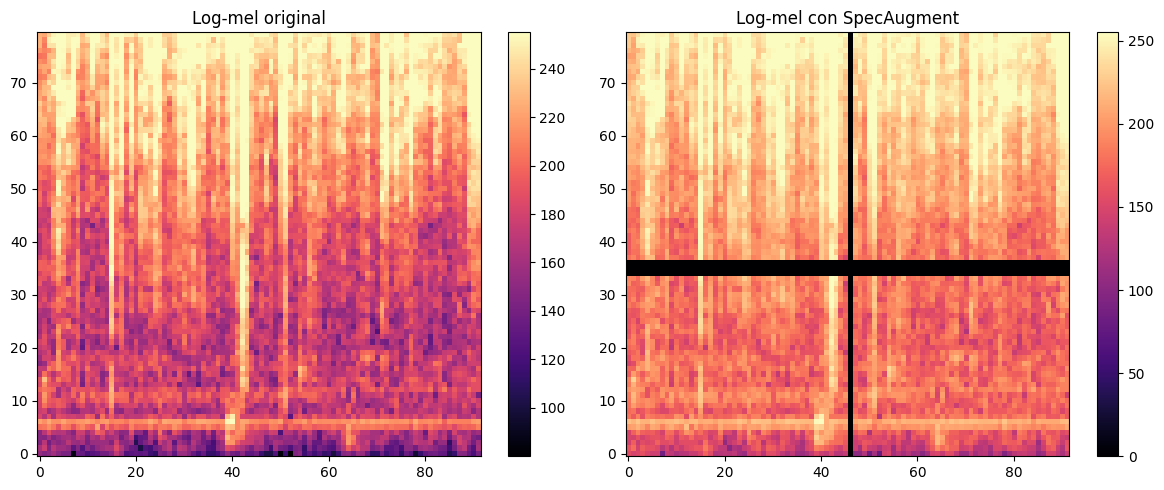

In [13]:


log_mel_ori_np = log_mel_ori.numpy().squeeze()
log_mel_aug_np = log_mel_augmented.numpy().squeeze()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(log_mel_ori_np.T, origin="lower", aspect="auto", cmap="magma")
plt.title("Log-mel original")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(log_mel_aug_np.T, origin="lower", aspect="auto", cmap="magma")
plt.title("Log-mel con SpecAugment")
plt.colorbar()

plt.tight_layout()
plt.show()

# METRICA

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import label_ranking_average_precision_score

def _lwlrap_sklearn(truth, scores):
    """Reference implementation from https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8"""
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap


def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example

    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c

    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='lwlrap', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros',
        )

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros',
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32),
        )

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(tf.zeros_like(self._precisions))
        self._counts.assign(tf.zeros_like(self._counts))

    def get_config(self):
        config = super().get_config()
        config.update({
            'num_classes': self.num_classes,
        })
        return config


# class LWLRAP(tf.keras.metrics.Metric):
#     def __init__(self, num_classes, name='lwlrap'):
#         super().__init__(name=name)

#         self._precisions = self.add_weight(
#             name='per_class_cumulative_precision',
#             shape=[num_classes],
#             initializer='zeros',
#         )

#         self._counts = self.add_weight(
#             name='per_class_cumulative_count',
#             shape=[num_classes],
#             initializer='zeros',
#         )

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         precisions = tf.map_fn(
#             fn=_one_sample_positive_class_precisions,
#             elems=(y_true, y_pred),
#             dtype=(tf.float32),
#         )

#         increments = tf.cast(precisions > 0, tf.float32)
#         total_increments = tf.reduce_sum(increments, axis=0)
#         total_precisions = tf.reduce_sum(precisions, axis=0)

#         self._precisions.assign_add(total_precisions)
#         self._counts.assign_add(total_increments)        

#     def result(self):
#         per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
#         per_class_weight = self._counts / tf.reduce_sum(self._counts)
#         overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
#         return overall_lwlrap

#     def reset_states(self):
#         self._precisions.assign(self._precisions * 0)
#         self._counts.assign(self._counts * 0)


def test_match_sklearn():

    # Generate dummy data like https://colab.research.google.com/drive/1YwL7ewUE6vSLZRoSf3Oi9efyupLyfcdb
    num_samples = 100
    num_labels = 20
    scores = np.random.rand(num_samples, num_labels)
    truth = np.random.rand(num_samples, num_labels) > 0.5
    truth[0:1, :] = False

    # Compute expected overall LWLRAP.
    desired = _lwlrap_sklearn(truth, scores)

    # Accumulate LWLRAP per minibatch with tf.metrics.Metric.
    metric = LWLRAP(num_labels)
    batch_size = 1
    for i in range(0, num_samples, batch_size):
        y_true = truth[i:i+batch_size]
        y_pred = scores[i:i+batch_size]
        x = metric.update_state(y_true, y_pred)
    actual = metric.result()

    # Make sure both methods get similar averages.
    np.testing.assert_allclose(actual, desired)


if __name__ == '__main__':
    test_match_sklearn()

# Modelos

In [15]:
# armar todo el codigo con lo de comet incluido y con la metrica que dado el ds_val y ds_train definidos clasifique y use la metrica que se usa en el problema.

Para ver de qué tamaño son nuestros espectogramas y que valores tienen - es necesario correrla para tener el tamaño input_shape_log_mel

In [16]:
for i in range(5):
    df_codif = codificar_etiquetas(df_train_curados) # es curado
    ruta   = 'train_curated_sin_silencios/'
    nombre = df_train_curados['fname'][i]
    label = df_train_curados['labels'][i]
    
    #print(nombre)
    print(label)
    
    ruta_audio = ruta + nombre
    
    img, label = preprocesamiento(ruta_audio, label)
    
    print('Tamaño matriz log_mel',img.shape)
    print('Minimo valor de log_mel',np.min(img.numpy()))
    print('Máximo valor de log_mel',np.max(img.numpy()))
    
    input_shape_log_mel = img.shape
    
    #print(input_shape_log_mel) 

# EXPLICACION DE DIMENSIONES:

# con 3 segundos de audio queda de (92,80)
# con 2 segundos de audio queda de (61,80)
# con 1 segundos de audio queda de (30,80)

# RESPONDE A:
    # COLUMNAS: num_mel_bins = 80
    
    # FILAS:
        # frame_length = 1024
        # frame_step = 512
        # N = fs * duracion(s)   # cantidad de muestras
        # cant_frames = 1+floor((N-frame_length)/frame_step) = 1+floor()

# EJ: si fs=16kHz y usamos 3 segundos entonces N=48000 y cant_frames = 92

Bark
Tamaño matriz log_mel (92, 80, 1)
Minimo valor de log_mel 101.09034
Máximo valor de log_mel 255.0
Raindrop
Tamaño matriz log_mel (92, 80, 1)
Minimo valor de log_mel 0.0
Máximo valor de log_mel 255.0
Finger_snapping
Tamaño matriz log_mel (92, 80, 1)
Minimo valor de log_mel 90.81314
Máximo valor de log_mel 255.0
Run
Tamaño matriz log_mel (92, 80, 1)
Minimo valor de log_mel 133.46045
Máximo valor de log_mel 255.0
Finger_snapping
Tamaño matriz log_mel (92, 80, 1)
Minimo valor de log_mel 0.0
Máximo valor de log_mel 255.0


### FUNCIONES QUE SE USAN EN LOS MODELOS

In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.BatchNormalization()(inputs)    
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.BatchNormalization()(x)    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)  # <-- esta capa aplana sin romper la forma
    x = layers.BatchNormalization()(x)    
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # sin activación, logits
    model = keras.Model(inputs, outputs)
    return model

In [18]:
def make_model_cabeza(x, num_classes):
    x = layers.BatchNormalization()(x) 
    
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.BatchNormalization()(x)    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)    
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    return outputs


def make_resnet50_model_cabeza(input_shape=(224, 224, 3), num_classes=80,capas_entrenables=0,cabeza_basica=False):
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling= None,
    )
    if capas_entrenables == 0:
        base_model.trainable = False  # Congela pesos
    else:
        base_model.trainable = True # habilito todo
        for layer in base_model.layers[:-capas_entrenables]: # deshabilito las ultimas
            layer.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)  # Normalizar
    x = base_model(x, training=(capas_entrenables > 0)) # si entreno capas entonces quiero que haya entrenamiento y da True sino da false
    if cabeza_basica:
        x = layers.GlobalAveragePooling2D()(x)  # pasar a 2D
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Multilabel
    else:   
        outputs= make_model_cabeza(x, num_classes)
    model = keras.Model(inputs, outputs)
    return model


In [19]:
from tensorflow.keras.applications import MobileNetV2

def make_mobilenet_model_cabeza(input_shape=(224, 224, 3), num_classes=80, capas_entrenables=0, cabeza_basica=False):
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None
    )

    if capas_entrenables == 0:
        base_model.trainable = False
    else:
        base_model.trainable = True

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=(capas_entrenables > 0))

    if cabeza_basica:
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Para multilabel
    else:
        outputs = make_model_cabeza(x, num_classes)

    model = keras.Model(inputs, outputs)
    return model


In [20]:
def preprocesamiento3canalesresnet(ruta_audio, label):
    waveform, sample_rate = largo_fijo(ruta_audio)
    log_mel = audio_a_imagen(waveform, sample_rate)  

    log_mel = tf.expand_dims(log_mel, axis=-1)          
    log_mel = tf.image.grayscale_to_rgb(log_mel)        
    # log_mel = tf.image.resize(log_mel, [224, 224],crop_to_aspect_ratio=True)      
    log_mel = tf.image.resize_with_pad(log_mel, 224, 224) # el anterior da error!

    log_mel = tf.keras.applications.resnet50.preprocess_input(log_mel)

    return log_mel, label

In [21]:
def preprocesamiento3canalesmobile(ruta_audio, label):
    waveform, sample_rate = largo_fijo(ruta_audio)
    log_mel = audio_a_imagen(waveform, sample_rate)  

    log_mel = tf.expand_dims(log_mel, axis=-1)          
    log_mel = tf.image.grayscale_to_rgb(log_mel)        
    # log_mel = tf.image.resize(log_mel, [224, 224],crop_to_aspect_ratio=True)      
    log_mel = tf.image.resize_with_pad(log_mel, 224, 224) # el anterior da error!

    log_mel = tf.keras.applications.mobilenet_v2.preprocess_input(log_mel)

    return log_mel, label

In [22]:
def crear_datasets_train_val(df,carpeta_audio='train_curated_sin_silencios',prep=None,batch_size=32,ratio=0.2,shuffle=True):
    # """
    # prep es comun o resnet 
    # """
    df_train_, df_val_ = train_test_split(df, test_size=ratio, shuffle=shuffle, random_state=42)

    df_train_80 = codificar_etiquetas(df_train_)
    df_val_80 = codificar_etiquetas(df_val_)

    carpeta_audio = carpeta_audio+'/' # ojo que acá se agrega la barra

    file_paths_train = [carpeta_audio + fname for fname in df_train_80['fname']]
    file_paths_val = [carpeta_audio + fname for fname in df_val_80['fname']] 

    label_vectors_train = df_train_80['label_vec'].tolist()
    label_vectors_val   = df_val_80['label_vec'].tolist()

    ds_train = tf.data.Dataset.from_tensor_slices((file_paths_train, label_vectors_train))
    ds_val   = tf.data.Dataset.from_tensor_slices((file_paths_val, label_vectors_val))

    if prep == 'comun':
        ds_train = ds_train.map(preprocesamiento, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val   = ds_val.map(preprocesamiento, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'resnet':
            ds_train = ds_train.map(preprocesamiento3canalesresnet, num_parallel_calls=tf.data.AUTOTUNE)
            ds_val   = ds_val.map(preprocesamiento3canalesresnet, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'mobile':
        ds_train = ds_train.map(preprocesamiento3canalesmobile, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val   = ds_val.map(preprocesamiento3canalesmobile, num_parallel_calls=tf.data.AUTOTUNE)

    ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_val

In [23]:
# Preprocesamientos con aumentado de datos

spec_augment = SpecAugment(freq_mask_param=5,
                           time_mask_param=5,
                           n_freq_mask=1,
                           n_time_mask=1,
                           mask_value=-100)

def preprocesamiento_aumentado(ruta_audio,label): # ojo que esta funcion no deja pasar parametros de las funciones que tiene dentro
    '''
    ruta_carpeta: ruta a la carpeta con wav  in silencios y resampleada
    label: posta 80
    '''
    log_mel, label = preprocesamiento(ruta_audio,label) # genero log_mel

    log_mel_aumentado = spec_augment(tf.expand_dims(log_mel, 0), training=True) # agrego dim extra para q ande
    log_mel_aumentado_reescalado = tf.squeeze(log_mel_aumentado, axis=0)  # saco dim extra

    return log_mel_aumentado_reescalado,label


def preprocesamiento3canalesresnet_aumentado(ruta_audio, label):

    log_mel, label = preprocesamiento3canalesresnet(ruta_audio,label) # genero log_mel

    log_mel_aumentado = spec_augment(tf.expand_dims(log_mel, 0), training=True) # agrego dim extra para q ande
    log_mel_aumentado_reescalado = tf.squeeze(log_mel_aumentado, axis=0)  # saco dim extra

    return log_mel_aumentado_reescalado,label

def preprocesamiento3canalesmobile_aumentado(ruta_audio, label):

    log_mel, label = preprocesamiento3canalesmobile(ruta_audio,label) # genero log_mel

    log_mel_aumentado = spec_augment(tf.expand_dims(log_mel, 0), training=True) # agrego dim extra para q ande
    log_mel_aumentado_reescalado = tf.squeeze(log_mel_aumentado, axis=0)  # saco dim extra

    return log_mel_aumentado_reescalado,label


def preprocesamiento_aumentado_porcentual(ruta_audio, label, p=0.5):
    log_mel, label = preprocesamiento(ruta_audio, label)
    if tf.random.uniform([]) < p:
        log_mel = spec_augment(tf.expand_dims(log_mel, 0), training=True)
        log_mel = tf.squeeze(log_mel, axis=0)
    return log_mel, label

def preprocesamiento3canalesresnet_aumentado_porcentual(ruta_audio, label, p=0.5):
    log_mel, label = preprocesamiento3canalesresnet(ruta_audio, label)
    if tf.random.uniform([]) < p:
        log_mel = spec_augment(tf.expand_dims(log_mel, 0), training=True)
        log_mel = tf.squeeze(log_mel, axis=0)
    return log_mel, label

def preprocesamiento3canalesmobile_aumentado_porcentual(ruta_audio, label, p=0.5):
    log_mel, label = preprocesamiento3canalesmobile(ruta_audio, label)
    if tf.random.uniform([]) < p:
        log_mel = spec_augment(tf.expand_dims(log_mel, 0), training=True)
        log_mel = tf.squeeze(log_mel, axis=0)
    return log_mel, label

In [24]:
def crear_datasets_train_val_aumentado(df,carpeta_audio=None,prep=None,batch_size=32,ratio=0.2,shuffle=True):
    # """
    # prep es comun o resnet 
    # """
    df_train_, df_val_ = train_test_split(df, test_size=ratio, shuffle=shuffle, random_state=42)

    df_train_80 = codificar_etiquetas(df_train_)
    df_val_80 = codificar_etiquetas(df_val_)

    carpeta_audio = carpeta_audio+'/' # ojo que acá se agrega la barra

    file_paths_train = [carpeta_audio + fname for fname in df_train_80['fname']]
    file_paths_val = [carpeta_audio + fname for fname in df_val_80['fname']] 

    label_vectors_train = df_train_80['label_vec'].tolist()
    label_vectors_val   = df_val_80['label_vec'].tolist()

    ds_train = tf.data.Dataset.from_tensor_slices((file_paths_train, label_vectors_train))
    ds_val   = tf.data.Dataset.from_tensor_slices((file_paths_val, label_vectors_val))

    if prep == 'comun':
        ds_train = ds_train.map(preprocesamiento_aumentado, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val   = ds_val.map(preprocesamiento, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'resnet':
            ds_train = ds_train.map(preprocesamiento3canalesresnet_aumentado, num_parallel_calls=tf.data.AUTOTUNE)
            ds_val   = ds_val.map(preprocesamiento3canalesresnet, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'mobile':
            ds_train = ds_train.map(preprocesamiento3canalesmobile_aumentado, num_parallel_calls=tf.data.AUTOTUNE)
            ds_val   = ds_val.map(preprocesamiento3canalesmobile, num_parallel_calls=tf.data.AUTOTUNE)

    ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_val




def crear_datasets_train_val_aumentado_porcentual(df,carpeta_audio=None,prep=None,batch_size=32,ratio=0.2,shuffle=True):
    # """
    # prep es comun o resnet 
    # """
    df_train_, df_val_ = train_test_split(df, test_size=ratio, shuffle=shuffle, random_state=42)

    df_train_80 = codificar_etiquetas(df_train_)
    df_val_80 = codificar_etiquetas(df_val_)

    carpeta_audio = carpeta_audio+'/' # ojo que acá se agrega la barra

    file_paths_train = [carpeta_audio + fname for fname in df_train_80['fname']]
    file_paths_val = [carpeta_audio + fname for fname in df_val_80['fname']] 

    label_vectors_train = df_train_80['label_vec'].tolist()
    label_vectors_val   = df_val_80['label_vec'].tolist()

    ds_train = tf.data.Dataset.from_tensor_slices((file_paths_train, label_vectors_train))
    ds_val   = tf.data.Dataset.from_tensor_slices((file_paths_val, label_vectors_val))

    if prep == 'comun':
        ds_train = ds_train.map(preprocesamiento_aumentado_porcentual, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val   = ds_val.map(preprocesamiento, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'resnet':
            ds_train = ds_train.map(preprocesamiento3canalesresnet_aumentado_porcentual, num_parallel_calls=tf.data.AUTOTUNE)
            ds_val   = ds_val.map(preprocesamiento3canalesresnet, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'mobile':
            ds_train = ds_train.map(preprocesamiento3canalesmobile_aumentado_porcentual, num_parallel_calls=tf.data.AUTOTUNE)
            ds_val   = ds_val.map(preprocesamiento3canalesmobile_porcentual, num_parallel_calls=tf.data.AUTOTUNE)

    ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds_train, ds_val

In [25]:
def cargar_a_comet(history, exp, optimizer='adam', epochs=50):
    '''
    Ver si queremos cargar el lr, como lo vamos cambiando lo saqué
    '''
    train_loss = history.history.get("loss")
    train_acc = history.history.get("acc")
    train_lwlrap = history.history.get("lwlrap")
    
    val_loss = history.history.get("val_loss")
    val_acc = history.history.get("val_acc")
    val_lwlrap = history.history.get("val_lwlrap")
    
    if val_lwlrap:
        best_epoch = np.argmax(val_lwlrap)
    else:
        best_epoch = np.argmin(val_loss)
    
    best_train_loss = train_loss[best_epoch] if train_loss else None
    best_train_acc = train_acc[best_epoch] if train_acc else None
    best_train_lwlrap = train_lwlrap[best_epoch] if train_lwlrap else None

    best_val_loss = val_loss[best_epoch] if val_loss else None
    best_val_acc = val_acc[best_epoch] if val_acc else None
    best_val_lwlrap = val_lwlrap[best_epoch] if val_lwlrap else None
    
    for metric_name, values in history.history.items():
        for epoch, value in enumerate(values):
            exp.log_metric(metric_name, value, step=epoch)
    
    exp.log_metrics({
        "best_train_loss": best_train_loss,
        "best_train_acc": best_train_acc,
        "best_train_lwlrap": best_train_lwlrap,
        "best_val_loss": best_val_loss,
        "best_val_acc": best_val_acc,
        "best_val_lwlrap": best_val_lwlrap,
    })
    
    exp.log_parameters({
        "optimizer": optimizer,
        "loss": 'binary_crossentropy',
        "epochs": epochs
    })
    
    exp.end()

## MODELO BASICO 1

In [41]:
ds_train_curados,ds_val_curados = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='comun',batch_size=32,ratio=0.2,shuffle=True)

In [40]:
ds_train_ruidosos,ds_val_ruidosos = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='comun',batch_size=32,ratio=0.2,shuffle=True)

In [42]:
ds_total_train = ds_train_ruidosos.concatenate(ds_train_curados)
ds_total_train = ds_total_train.concatenate(ds_val_ruidosos)
ds_total_val = ds_val_curados


In [43]:
model_basico = make_model(input_shape=input_shape_log_mel, num_classes=80)

In [44]:
model_basico.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc"), LWLRAP(num_classes=80)]
)

history_basico = model_basico.fit(
    ds_total_train,
    epochs=15,
    validation_data=ds_total_val,
)

Epoch 1/15


C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


745/745 [==============================] - ETA: 0s - loss: 0.1441 - acc: 0.9631 - lwlrap: 0.0902

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


745/745 [==============================] - 153s 203ms/step - loss: 0.1441 - acc: 0.9631 - lwlrap: 0.0902 - val_loss: 0.0824 - val_acc: 0.9854 - val_lwlrap: 0.1114
Epoch 2/15
745/745 [==============================] - 153s 206ms/step - loss: 0.0796 - acc: 0.9850 - lwlrap: 0.1309 - val_loss: 0.0737 - val_acc: 0.9854 - val_lwlrap: 0.1665
Epoch 3/15
745/745 [==============================] - 144s 193ms/step - loss: 0.0741 - acc: 0.9850 - lwlrap: 0.1625 - val_loss: 0.0700 - val_acc: 0.9854 - val_lwlrap: 0.1955
Epoch 4/15
745/745 [==============================] - 117s 157ms/step - loss: 0.0716 - acc: 0.9850 - lwlrap: 0.1890 - val_loss: 0.0693 - val_acc: 0.9854 - val_lwlrap: 0.2048
Epoch 5/15
745/745 [==============================] - 111s 148ms/step - loss: 0.0702 - acc: 0.9850 - lwlrap: 0.2079 - val_loss: 0.0676 - val_acc: 0.9855 - val_lwlrap: 0.2231
Epoch 6/15
745/745 [==============================] - 109s 147ms/step - loss: 0.0693 - acc: 0.9850 - lwlrap: 0.2197 - val_loss: 0.0672 - val_

##  Modelo basico con Resnet

In [54]:
ds_train_3canales_C,ds_val_3canales_C = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='resnet',batch_size=32,ratio=0.2,shuffle=True)
ds_train_3canales_R,ds_val_3canales_R = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='resnet',batch_size=32,ratio=0.2,shuffle=True)

In [55]:
ds_total_train_resnet = ds_train_3canales_C.concatenate(ds_train_3canales_R)
ds_total_train_resnet = ds_total_train_resnet.concatenate(ds_val_3canales_R)
ds_total_val_resnet = ds_val_3canales_C


### Train / val

#### modelo con densas model_1

In [56]:
model_resnet = make_resnet50_model_cabeza(cabeza_basica=True)

model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=[LWLRAP(num_classes=80)]
)

In [57]:


history_resnet = model_resnet.fit(ds_total_train_resnet,epochs=15,validation_data=ds_total_val_resnet)


Epoch 1/15
745/745 [==============================] - ETA: 0s - loss: 0.1019 - lwlrap: 0.0673

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


745/745 [==============================] - 184s 240ms/step - loss: 0.1019 - lwlrap: 0.0673 - val_loss: 0.0766 - val_lwlrap: 0.0675
Epoch 2/15
745/745 [==============================] - 178s 239ms/step - loss: 0.0817 - lwlrap: 0.0692 - val_loss: 0.0762 - val_lwlrap: 0.0776
Epoch 3/15
745/745 [==============================] - 177s 238ms/step - loss: 0.0802 - lwlrap: 0.0764 - val_loss: 0.0758 - val_lwlrap: 0.0781
Epoch 4/15
745/745 [==============================] - 176s 236ms/step - loss: 0.0791 - lwlrap: 0.0840 - val_loss: 0.0756 - val_lwlrap: 0.0868
Epoch 5/15
745/745 [==============================] - 184s 246ms/step - loss: 0.0782 - lwlrap: 0.0927 - val_loss: 0.0757 - val_lwlrap: 0.0901
Epoch 6/15
745/745 [==============================] - 177s 237ms/step - loss: 0.0777 - lwlrap: 0.0994 - val_loss: 0.0756 - val_lwlrap: 0.0928
Epoch 7/15
745/745 [==============================] - 177s 238ms/step - loss: 0.0773 - lwlrap: 0.1045 - val_loss: 0.0753 - val_lwlrap: 0.1006
Epoch 8/15
745/74

##  Modelo basico con MOBILE

In [58]:
ds_train_3canales_mobile_C ,ds_val_3canales_mobile_C = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=32,ratio=0.2,shuffle=True)

In [59]:
ds_train_3canales_mobile_R ,ds_val_3canales_mobile_R = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='mobile',batch_size=32,ratio=0.2,shuffle=True)

In [60]:
ds_total_train_mobile = ds_train_3canales_mobile_C.concatenate(ds_train_3canales_mobile_R)
ds_total_train_mobile = ds_total_train_mobile.concatenate(ds_val_3canales_mobile_R)
ds_total_val_mobile = ds_val_3canales_mobile_C

In [61]:
model_mobile = make_mobilenet_model_cabeza(cabeza_basica=True)

model_mobile.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', LWLRAP(num_classes=80)]
)
history_mobile = model_mobile.fit(ds_total_train_mobile ,epochs=15,validation_data=ds_total_val_mobile)

Epoch 1/15
745/745 [==============================] - ETA: 0s - loss: 0.1008 - binary_accuracy: 0.9788 - lwlrap: 0.0678

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


745/745 [==============================] - 170s 222ms/step - loss: 0.1008 - binary_accuracy: 0.9788 - lwlrap: 0.0678 - val_loss: 0.0765 - val_binary_accuracy: 0.9854 - val_lwlrap: 0.0727
Epoch 2/15
745/745 [==============================] - 163s 219ms/step - loss: 0.0820 - binary_accuracy: 0.9850 - lwlrap: 0.0698 - val_loss: 0.0760 - val_binary_accuracy: 0.9854 - val_lwlrap: 0.0826
Epoch 3/15
745/745 [==============================] - 163s 218ms/step - loss: 0.0805 - binary_accuracy: 0.9850 - lwlrap: 0.0760 - val_loss: 0.0756 - val_binary_accuracy: 0.9854 - val_lwlrap: 0.0846
Epoch 4/15
745/745 [==============================] - 162s 217ms/step - loss: 0.0794 - binary_accuracy: 0.9850 - lwlrap: 0.0821 - val_loss: 0.0754 - val_binary_accuracy: 0.9854 - val_lwlrap: 0.0925
Epoch 5/15
745/745 [==============================] - 164s 219ms/step - loss: 0.0786 - binary_accuracy: 0.9850 - lwlrap: 0.0912 - val_loss: 0.0754 - val_binary_accuracy: 0.9854 - val_lwlrap: 0.0932
Epoch 6/15
745/745 [=

## Comparacion de modelos sin nada

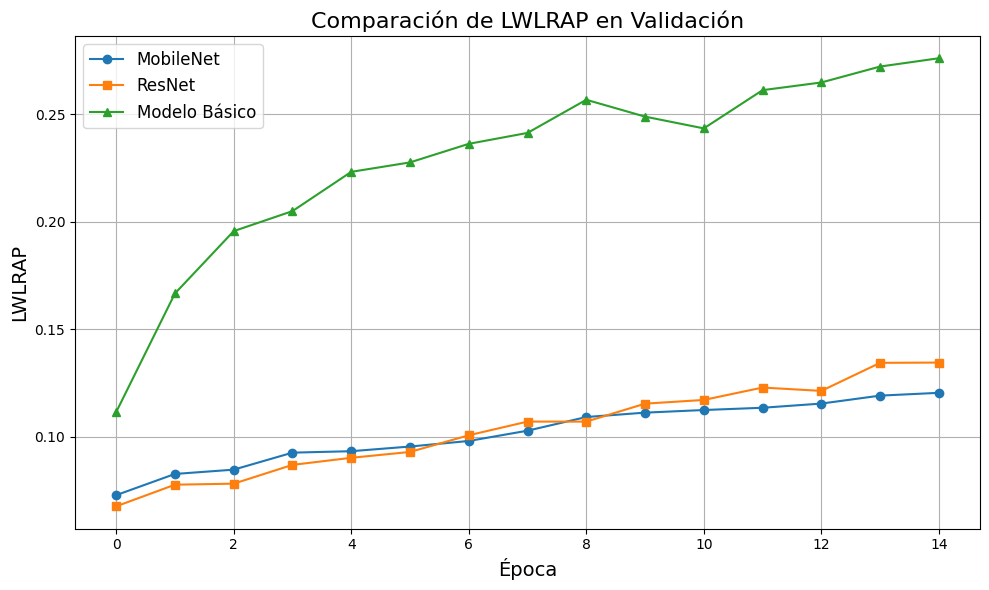

In [63]:
mobile_val_lwlrap = history_mobile.history['val_lwlrap']
resnet_val_lwlrap = history_resnet.history['val_lwlrap']
basico_val_lwlrap = history_basico.history['val_lwlrap']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mobile_val_lwlrap, label='MobileNet', marker='o')
plt.plot(resnet_val_lwlrap, label='ResNet', marker='s')
plt.plot(basico_val_lwlrap, label='Modelo Básico', marker='^')

plt.title('Comparación de LWLRAP en Validación', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('LWLRAP', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [174]:
model_basico.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 92, 80, 1)]       0         
                                                                 
 batch_normalization_3 (Batc  (None, 92, 80, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 80, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 40, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 46, 40, 32)       128       
 hNormalization)                                                 
                                                           

In [175]:
model_resnet.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                           

In [176]:
model_mobile.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               327936    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0   

### Aumentado con %

## Basico

In [69]:
ds_train_ruidosos,ds_val_ruidosos = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='comun',batch_size=32,ratio=0.2,shuffle=True)

In [64]:
ds_train_curados,ds_val_curados = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='comun',batch_size=32,ratio=0.2,shuffle=True)

In [65]:
# no se aplica aumentado en val, es solo el nombre para distinguir
ds_train_curados_aumentado,ds_val_curados_aumentado = crear_datasets_train_val_aumentado(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='comun',batch_size=16,ratio=0.2,shuffle=True)

In [70]:
ds_train_aumentado = ds_train_ruidosos.concatenate(ds_val_ruidosos)
ds_train_aumentado=ds_train_aumentado.concatenate(ds_train_curados)
ds_train_aumentado=ds_train_aumentado.concatenate(ds_train_curados_aumentado)
ds_train_aumentado=ds_train_aumentado.concatenate(ds_val_curados_aumentado)

ds_val_aumentado = ds_val_curados

In [72]:
model_basico_aumentado = make_model(input_shape=input_shape_log_mel, num_classes=80)
model_basico_aumentado.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[LWLRAP(num_classes=80)]
)

history_basico_aumentado = model_basico_aumentado.fit(
    ds_train_aumentado,
    epochs=20,
    validation_data=ds_val_aumentado,
)

Epoch 1/20


C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1057/1057 [==============================] - 167s 156ms/step - loss: 0.1294 - lwlrap: 0.0965 - val_loss: 0.0744 - val_lwlrap: 0.1562
Epoch 2/20
1057/1057 [==============================] - 169s 159ms/step - loss: 0.0763 - lwlrap: 0.1463 - val_loss: 0.0689 - val_lwlrap: 0.2052
Epoch 3/20
1057/1057 [==============================] - 169s 160ms/step - loss: 0.0720 - lwlrap: 0.1775 - val_loss: 0.0661 - val_lwlrap: 0.2364
Epoch 4/20
1057/1057 [==============================] - 170s 161ms/step - loss: 0.0700 - lwlrap: 0.2026 - val_loss: 0.0642 - val_lwlrap: 0.2594
Epoch 5/20
1057/1057 [==============================] - 170s 161ms/step - loss: 0.0686 - lwlrap: 0.2230 - val_loss: 0.0632 - val_lwlrap: 0.2677
Epoch 6/20
1057/1057 [==============================] - 171s 162ms/step - loss: 0.0676 - lwlrap: 0.2370 - val_loss: 0.0632 - val_lwlrap: 0.2733
Epoch 7/20
1057/1057 [==============================] - 171s 162ms/step - loss: 0.0668 - lwlrap: 0.2491 - val_loss: 0.0631 - val_lwlrap: 0.2795
Epo

## Resnet

In [73]:
ds_train_ruidosos_R ,ds_val_ruidosos_R = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='resnet',batch_size=32,ratio=0.2,shuffle=True)

ds_train_curados_R,ds_val_curados_R = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='resnet',batch_size=32,ratio=0.2,shuffle=True)

ds_train_curados_aumentado_R,ds_val_curados_aumentado_R = crear_datasets_train_val_aumentado(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='resnet',batch_size=16,ratio=0.2,shuffle=True)

In [74]:
ds_train_aumentado_R = ds_train_ruidosos_R.concatenate(ds_val_ruidosos_R)
ds_train_aumentado_R=ds_train_aumentado_R.concatenate(ds_train_curados_R)
ds_train_aumentado_R=ds_train_aumentado_R.concatenate(ds_train_curados_aumentado_R)
ds_train_aumentado_R=ds_train_aumentado_R.concatenate(ds_val_curados_aumentado_R)

ds_val_aumentado_R = ds_val_curados_R

In [75]:
model_resnet_aumentado = make_resnet50_model_cabeza(cabeza_basica=False)

model_resnet_aumentado.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=[LWLRAP(num_classes=80)]
)

history_resnet_aumentado = model_resnet_aumentado.fit(ds_train_aumentado_R,epochs=20,validation_data=ds_val_aumentado_R)



Epoch 1/20
1057/1057 [==============================] - ETA: 0s - loss: 0.1242 - lwlrap: 0.0863

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1057/1057 [==============================] - 221s 203ms/step - loss: 0.1242 - lwlrap: 0.0863 - val_loss: 0.0744 - val_lwlrap: 0.2007
Epoch 2/20
1057/1057 [==============================] - 209s 197ms/step - loss: 0.0785 - lwlrap: 0.1231 - val_loss: 0.0670 - val_lwlrap: 0.2662
Epoch 3/20
1057/1057 [==============================] - 202s 191ms/step - loss: 0.0749 - lwlrap: 0.1563 - val_loss: 0.0655 - val_lwlrap: 0.2787
Epoch 4/20
1057/1057 [==============================] - 203s 192ms/step - loss: 0.0728 - lwlrap: 0.1747 - val_loss: 0.0695 - val_lwlrap: 0.2531
Epoch 5/20
1057/1057 [==============================] - 204s 193ms/step - loss: 0.0713 - lwlrap: 0.1917 - val_loss: 0.0653 - val_lwlrap: 0.2914
Epoch 6/20
1057/1057 [==============================] - 206s 195ms/step - loss: 0.0702 - lwlrap: 0.2065 - val_loss: 0.0616 - val_lwlrap: 0.3421
Epoch 7/20
1057/1057 [==============================] - 206s 194ms/step - loss: 0.0693 - lwlrap: 0.2182 - val_loss: 0.0596 - val_lwlrap: 0.3526
Epo

## Mobile

In [169]:
ds_train_ruidosos_M ,ds_val_ruidosos_M = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='mobile',batch_size=32,ratio=0.2,shuffle=True)

ds_train_curados_M,ds_val_curados_M = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=32,ratio=0.2,shuffle=True)

ds_train_curados_aumentado_M = ds_train_curados_M.map(
    lambda x, y: (spec_augment(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [170]:
ds_train_aumentado_M = ds_train_ruidosos_M.concatenate(ds_val_ruidosos_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_aumentado_M)
#ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_val_curados_aumentado_M)

ds_val_aumentado_M = ds_val_curados_M

In [172]:
model_mobile_aumentado2 = make_mobilenet_model_cabeza(cabeza_basica=True, capas_entrenables = 0)

model_mobile_aumentado2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=[LWLRAP(num_classes=80)]
)
history_mobile_aumentado2 = model_mobile_aumentado2.fit(ds_train_aumentado_M ,epochs=20,validation_data=ds_val_aumentado_M)

Epoch 1/20
870/870 [==============================] - 185s 207ms/step - loss: 0.0870 - lwlrap: 0.1486 - val_loss: 0.0618 - val_lwlrap: 0.3083
Epoch 2/20
870/870 [==============================] - 187s 215ms/step - loss: 0.0693 - lwlrap: 0.2339 - val_loss: 0.0576 - val_lwlrap: 0.3806
Epoch 3/20
870/870 [==============================] - 205s 235ms/step - loss: 0.0662 - lwlrap: 0.2720 - val_loss: 0.0558 - val_lwlrap: 0.3949
Epoch 4/20
870/870 [==============================] - 203s 233ms/step - loss: 0.0644 - lwlrap: 0.2982 - val_loss: 0.0544 - val_lwlrap: 0.4216
Epoch 5/20
870/870 [==============================] - 195s 224ms/step - loss: 0.0631 - lwlrap: 0.3155 - val_loss: 0.0534 - val_lwlrap: 0.4360
Epoch 6/20
870/870 [==============================] - 200s 229ms/step - loss: 0.0622 - lwlrap: 0.3293 - val_loss: 0.0528 - val_lwlrap: 0.4411
Epoch 7/20
870/870 [==============================] - 195s 224ms/step - loss: 0.0613 - lwlrap: 0.3413 - val_loss: 0.0520 - val_lwlrap: 0.4545
Epoch 

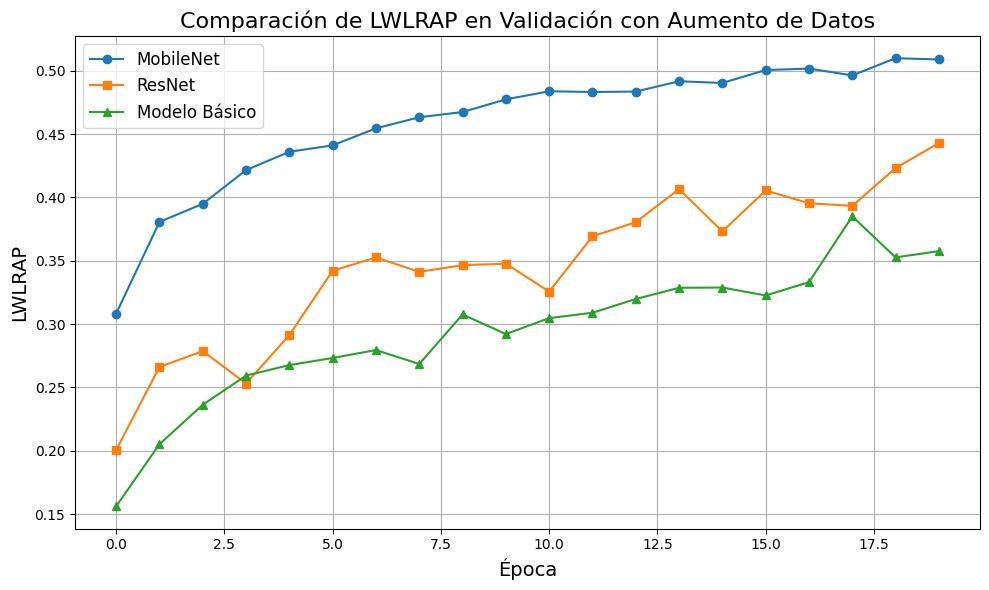

In [173]:
mobile_val_lwlrap_aumentado = history_mobile_aumentado2.history['val_lwlrap']
resnet_val_lwlrap_aumentado = history_resnet_aumentado.history['val_lwlrap']
basico_val_lwlrap_aumentado = history_basico_aumentado.history['val_lwlrap']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(mobile_val_lwlrap_aumentado, label='MobileNet', marker='o')
plt.plot(resnet_val_lwlrap_aumentado, label='ResNet', marker='s')
plt.plot(basico_val_lwlrap_aumentado, label='Modelo Básico', marker='^')

plt.title('Comparación de LWLRAP en Validación con Aumento de Datos', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('LWLRAP', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Combinar ambos

In [26]:
def make_model_mobile(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    
    x = layers.Rescaling(1.0 / 255)(inputs)

    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling=None  
    )
    base_model.trainable = True 

    x = base_model(x, training=True)

    x = layers.BatchNormalization()(x) 
    
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.BatchNormalization()(x)    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
    #x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)    
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    return model

# Crear modelo
model_mobilenet_mas_basico = make_model_mobile(input_shape=(224,224, 3), num_classes=80)

In [99]:
ds_train_ruidosos_M ,ds_val_ruidosos_M = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='mobile',batch_size=16,ratio=0.2,shuffle=True)

ds_train_curados_M,ds_val_curados_M = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=16,ratio=0.2,shuffle=True)

ds_train_curados_aumentado_M = ds_train_curados_M.map(
    lambda x, y: (spec_augment(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


#ds_train_curados_aumentado_M,ds_val_curados_aumentado_M = crear_datasets_train_val_aumentado(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=16,ratio=0.2,shuffle=True)

ds_train_aumentado_M = ds_train_ruidosos_M.concatenate(ds_val_ruidosos_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_aumentado_M)


ds_val_aumentado_M = ds_val_curados_M

In [100]:
model_mobilenet_mas_basico.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=[LWLRAP(num_classes=80)]
)
history_mobilenet_mas_basico = model_mobilenet_mas_basico.fit(ds_train_aumentado_M ,epochs=20,validation_data=ds_val_aumentado_M)

Epoch 1/20
1737/1737 [==============================] - ETA: 0s - loss: 0.1014 - lwlrap: 0.1193

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1737/1737 [==============================] - 234s 130ms/step - loss: 0.1014 - lwlrap: 0.1193 - val_loss: 0.0655 - val_lwlrap: 0.2686
Epoch 2/20
1737/1737 [==============================] - 224s 129ms/step - loss: 0.0708 - lwlrap: 0.2140 - val_loss: 0.0605 - val_lwlrap: 0.3395
Epoch 3/20
1737/1737 [==============================] - 224s 129ms/step - loss: 0.0663 - lwlrap: 0.2702 - val_loss: 0.0560 - val_lwlrap: 0.3925
Epoch 4/20
1737/1737 [==============================] - 225s 129ms/step - loss: 0.0635 - lwlrap: 0.3108 - val_loss: 0.0525 - val_lwlrap: 0.4468
Epoch 5/20
1737/1737 [==============================] - 225s 129ms/step - loss: 0.0610 - lwlrap: 0.3472 - val_loss: 0.0500 - val_lwlrap: 0.4799
Epoch 6/20
1737/1737 [==============================] - 224s 129ms/step - loss: 0.0589 - lwlrap: 0.3779 - val_loss: 0.0487 - val_lwlrap: 0.5044
Epoch 7/20
1737/1737 [==============================] - 225s 129ms/step - loss: 0.0569 - lwlrap: 0.4058 - val_loss: 0.0470 - val_lwlrap: 0.5195
Epo

In [27]:
ds_train_ruidosos_M ,ds_val_ruidosos_M = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='mobile',batch_size=8,ratio=0.2,shuffle=True)

ds_train_curados_M,ds_val_curados_M = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=8,ratio=0.2,shuffle=True)

ds_train_curados_aumentado_M = ds_train_curados_M.map(
    lambda x, y: (spec_augment(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


#ds_train_curados_aumentado_M,ds_val_curados_aumentado_M = crear_datasets_train_val_aumentado(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=16,ratio=0.2,shuffle=True)

ds_train_aumentado_M = ds_train_ruidosos_M.concatenate(ds_val_ruidosos_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_aumentado_M)


ds_val_aumentado_M = ds_val_curados_M
model_mobilenet_mas_basico_con_lr = make_model_mobile(input_shape=(224,224, 3), num_classes=80)

model_mobilenet_mas_basico_con_lr.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[LWLRAP(num_classes=80)]
)
history_mobilenet_mas_basico_con_lr = model_mobilenet_mas_basico_con_lr.fit(ds_train_aumentado_M ,epochs=20,validation_data=ds_val_aumentado_M)

Epoch 1/20



KeyboardInterrupt



In [28]:
ds_train_ruidosos_M ,ds_val_ruidosos_M = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='mobile',batch_size=8,ratio=0.2,shuffle=True)

ds_train_curados_M,ds_val_curados_M = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=8,ratio=0.2,shuffle=True)

ds_train_curados_aumentado_M = ds_train_curados_M.map(
    lambda x, y: (spec_augment(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


#ds_train_curados_aumentado_M,ds_val_curados_aumentado_M = crear_datasets_train_val_aumentado(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=16,ratio=0.2,shuffle=True)

ds_train_aumentado_M = ds_train_ruidosos_M.concatenate(ds_val_ruidosos_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_M)
ds_train_aumentado_M=ds_train_aumentado_M.concatenate(ds_train_curados_aumentado_M)


ds_val_aumentado_M = ds_val_curados_M
model_mobilenet_mas_basico_con_lr = make_model_mobile(input_shape=(224,224, 3), num_classes=80)

model_mobilenet_mas_basico_con_lr.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=[LWLRAP(num_classes=80)]
)
history_mobilenet_mas_basico_con_lr = model_mobilenet_mas_basico_con_lr.fit(ds_train_aumentado_M ,epochs=20,validation_data=ds_val_aumentado_M)

Epoch 1/20
Instructions for updating:
Use fn_output_signature instead
3472/3472 [==============================] - ETA: 0s - loss: 0.7303 - lwlrap: 0.0683

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


3472/3472 [==============================] - 306s 86ms/step - loss: 0.7303 - lwlrap: 0.0683 - val_loss: 0.6969 - val_lwlrap: 0.0719
Epoch 2/20
3472/3472 [==============================] - 270s 78ms/step - loss: 0.6716 - lwlrap: 0.0690 - val_loss: 0.6351 - val_lwlrap: 0.0701
Epoch 3/20
3472/3472 [==============================] - 268s 77ms/step - loss: 0.6200 - lwlrap: 0.0669 - val_loss: 0.5684 - val_lwlrap: 0.0688
Epoch 4/20
3472/3472 [==============================] - 267s 77ms/step - loss: 0.5713 - lwlrap: 0.0680 - val_loss: 0.5046 - val_lwlrap: 0.0667
Epoch 5/20
3472/3472 [==============================] - 268s 77ms/step - loss: 0.5223 - lwlrap: 0.0680 - val_loss: 0.4470 - val_lwlrap: 0.0657
Epoch 6/20
3472/3472 [==============================] - 268s 77ms/step - loss: 0.4740 - lwlrap: 0.0684 - val_loss: 0.3962 - val_lwlrap: 0.0659
Epoch 7/20
3472/3472 [==============================] - 269s 77ms/step - loss: 0.4267 - lwlrap: 0.0689 - val_loss: 0.3474 - val_lwlrap: 0.0684
Epoch 8/20

###### 

## RESNET


In [101]:
def make_model_resnet(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    
    x = layers.Rescaling(1.0 / 255)(inputs)

    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling= None,
    )
    base_model.trainable = True 

    x = base_model(x, training=True)

    x = layers.BatchNormalization()(x) 
    
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.BatchNormalization()(x)    
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same")(x)
    #x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)    
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    return model

# Crear modelo
model_resnet_mas_basico = make_model_resnet(input_shape=(224,224, 3), num_classes=80)

In [104]:
ds_train_ruidosos_R ,ds_val_ruidosos_R = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='resnet',batch_size=8,ratio=0.2,shuffle=True)

ds_train_curados_R,ds_val_curados_R = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='resnet',batch_size=8,ratio=0.2,shuffle=True)

ds_train_curados_aumentado_R = ds_train_curados_R.map(
    lambda x, y: (spec_augment(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)


#ds_train_curados_aumentado_M,ds_val_curados_aumentado_M = crear_datasets_train_val_aumentado(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='mobile',batch_size=16,ratio=0.2,shuffle=True)

ds_train_aumentado_R = ds_train_ruidosos_R.concatenate(ds_val_ruidosos_R)
ds_train_aumentado_R=ds_train_aumentado_R.concatenate(ds_train_curados_R)
ds_train_aumentado_R=ds_train_aumentado_R.concatenate(ds_train_curados_aumentado_R)


ds_val_aumentado_R = ds_val_curados_R

In [105]:
model_resnet_mas_basico.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='binary_crossentropy',
    metrics=[LWLRAP(num_classes=80)]
)
history_resnet_mas_basico = model_resnet_mas_basico.fit(ds_train_aumentado_R ,epochs=20,validation_data=ds_val_aumentado_R)

Epoch 1/20
3472/3472 [==============================] - ETA: 0s - loss: 0.0926 - lwlrap: 0.0969

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


3472/3472 [==============================] - 610s 173ms/step - loss: 0.0926 - lwlrap: 0.0969 - val_loss: 0.0725 - val_lwlrap: 0.1497
Epoch 2/20
3472/3472 [==============================] - 595s 171ms/step - loss: 0.0762 - lwlrap: 0.1223 - val_loss: 0.0747 - val_lwlrap: 0.1125
Epoch 3/20
3472/3472 [==============================] - 595s 171ms/step - loss: 0.0749 - lwlrap: 0.1376 - val_loss: 0.0693 - val_lwlrap: 0.2074
Epoch 4/20
3472/3472 [==============================] - 595s 171ms/step - loss: 0.0732 - lwlrap: 0.1596 - val_loss: 0.0697 - val_lwlrap: 0.2046
Epoch 5/20
3472/3472 [==============================] - 596s 172ms/step - loss: 0.0721 - lwlrap: 0.1749 - val_loss: 0.0683 - val_lwlrap: 0.2076
Epoch 6/20
3472/3472 [==============================] - 596s 172ms/step - loss: 0.0709 - lwlrap: 0.1907 - val_loss: 0.0674 - val_lwlrap: 0.2237
Epoch 7/20
3472/3472 [==============================] - 597s 172ms/step - loss: 0.0697 - lwlrap: 0.2077 - val_loss: 0.0645 - val_lwlrap: 0.2546
Epo

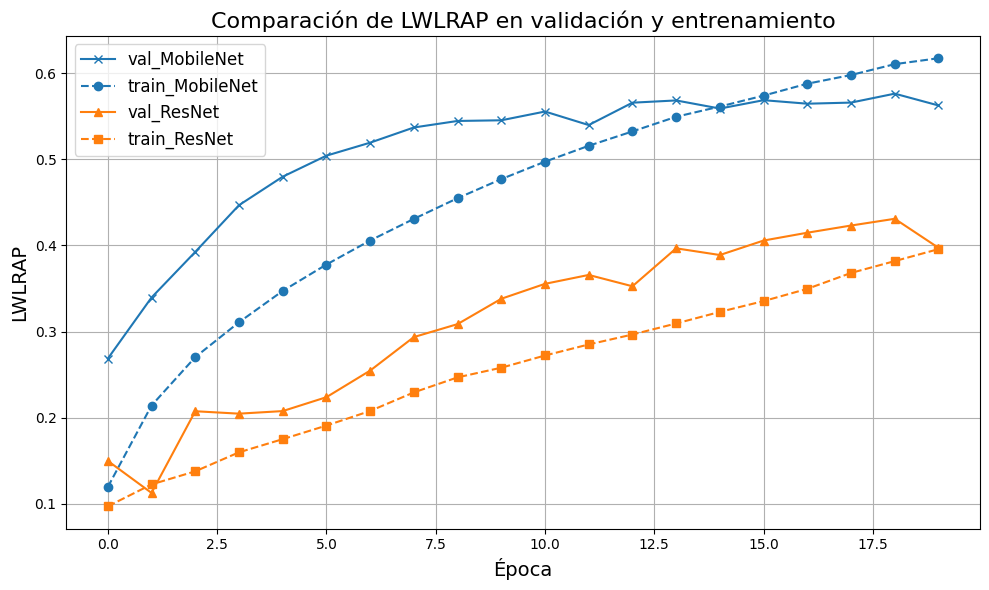

In [109]:
color_mobilenet = 'tab:blue'
color_resnet = 'tab:orange'

plt.figure(figsize=(10, 6))

# MobileNet
plt.plot(mobile_val_lwlrap_con_basico, label='val_MobileNet', color=color_mobilenet, linestyle='-',marker='x')
plt.plot(mobile_lwlrap_con_basico, label='train_MobileNet', color=color_mobilenet, linestyle='--',marker='o')

# ResNet
plt.plot(resnet_val_lwlrap_con_basico, label='val_ResNet', color=color_resnet, linestyle='-', marker='^')
plt.plot(resnet_lwlrap_con_basico, label='train_ResNet', color=color_resnet, linestyle='--',marker='s')

plt.title('Comparación de LWLRAP en validación y entrenamiento', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('LWLRAP', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [177]:
model_resnet_mas_basico.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_17 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_29 (Bat  (None, 7, 7, 2048)       8192      
 chNormalization)                                                
                                                                 
 conv2d_20 (Conv2D)          (None, 7, 7, 32)          589856    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                     

In [178]:
model_mobilenet_mas_basico.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 batch_normalization_26 (Bat  (None, 7, 7, 1280)       5120      
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 3, 3, 32)         0  

In [179]:
model_mobilenet_mas_basico.save('Mobilenetconbasico_entrenando_todo.keras')

In [180]:
Ver_mobile = keras.models.load_model('Mobilenetconbasico_entrenando_todo.keras',custom_objects={'LWLRAP': LWLRAP})

In [190]:
model_mobilenet_mas_basico.layers

In [195]:
from tensorflow.keras.applications import MobileNetV2
input_shape = (224, 224, 3)


print(f"Cantidad total de capas en MobileNetV2: {len(model_mobilenet_mas_basico.layers)}")
# Imprimir agrupado de 20 en 20 como referencia
for indices in zip(range(0, 20), range(20, 40), range(40, 60), range(60, 80), range(80, 100), range(100, 120), range(120, 140), range(140, len(model_mobilenet_mas_basico.layers))):
    for idx in indices:
        print(f"{idx:3}: {model_mobilenet_mas_basico.layers[idx].name:25}", end="")
    print()

Cantidad total de capas en MobileNetV2: 13


In [209]:
layer_name = "dense_29"
layer = model_mobilenet_mas_basico.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model_mobilenet_mas_basico.inputs, outputs=layer.output)

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


# Start from a random image that is close to "all gray" (i.e. visually netural)
def initialize_image(img_width,img_height):
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img


def visualize_filter(filter_index,img_width,img_height):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image(img_width,img_height)
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss,img

In [207]:
for i, layer in enumerate(model_mobilenet_mas_basico.layers):
    print(f"{i}: {layer.name} — {layer.__class__.__name__}")

0: input_29 — InputLayer
1: rescaling_16 — Rescaling
2: mobilenetv2_1.00_224 — Functional
3: batch_normalization_26 — BatchNormalization
4: conv2d_18 — Conv2D
5: max_pooling2d_15 — MaxPooling2D
6: batch_normalization_27 — BatchNormalization
7: conv2d_19 — Conv2D
8: global_average_pooling2d_14 — GlobalAveragePooling2D
9: batch_normalization_28 — BatchNormalization
10: dense_28 — Dense
11: dropout_14 — Dropout
12: dense_29 — Dense


In [200]:
base_model = model_mobilenet_mas_basico.get_layer("mobilenetv2_1.00_224")

## comparacion kernel size


In [115]:
from skmultilearn.model_selection import iterative_train_test_split

def crear_datasets_train_val_aumentado_strat(df,carpeta_audio=None,prep=None,batch_size=32,ratio=0.2):
    # """
    # prep es comun o resnet 
    # """
    df_codificado = codificar_etiquetas(df)

    X = df_codificado['fname'].values.reshape(-1, 1)  # reshape porque X debe ser 2D
    y = np.stack(df_codificado['label_vec'].values)   # convertir lista de vectores a array 

    X_train, y_train, X_val, y_val = iterative_train_test_split(X, y, test_size=ratio)

    # Reconstruir DataFrames
    df_train_ = pd.DataFrame({'fname': X_train.ravel(), 'label_vec': list(y_train)})
    df_val_   = pd.DataFrame({'fname': X_val.ravel(),   'label_vec': list(y_val)})

    carpeta_audio = carpeta_audio+'/' # ojo que acá se agrega la barra

    file_paths_train = [carpeta_audio + fname for fname in df_train_['fname']]
    file_paths_val = [carpeta_audio + fname for fname in df_val_['fname']] 

    label_vectors_train = df_train_['label_vec'].tolist()
    label_vectors_val   = df_val_['label_vec'].tolist()

    ds_train = tf.data.Dataset.from_tensor_slices((file_paths_train, label_vectors_train))
    ds_train_aumentado = tf.data.Dataset.from_tensor_slices((file_paths_train, label_vectors_train))
    ds_val   = tf.data.Dataset.from_tensor_slices((file_paths_val, label_vectors_val))


    if prep == 'comun':
        ds_train = ds_train.map(preprocesamiento, num_parallel_calls=tf.data.AUTOTUNE)
        ds_train_aumentado = ds_train_aumentado.map(preprocesamiento_aumentado, num_parallel_calls=tf.data.AUTOTUNE)
        ds_val   = ds_val.map(preprocesamiento, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'resnet':
            ds_train = ds_train.map(preprocesamiento3canalesresnet, num_parallel_calls=tf.data.AUTOTUNE)
            ds_train_aumentado = ds_train_aumentado.map(preprocesamiento3canalesresnet_aumentado, num_parallel_calls=tf.data.AUTOTUNE)
            ds_val   = ds_val.map(preprocesamiento3canalesresnet, num_parallel_calls=tf.data.AUTOTUNE)
    elif prep == 'mobile':
            ds_train = ds_train.map(preprocesamiento3canalesmobile, num_parallel_calls=tf.data.AUTOTUNE)
            ds_train_aumentado = ds_train_aumentado.map(preprocesamiento3canalesmobile_aumentado, num_parallel_calls=tf.data.AUTOTUNE)
            ds_val   = ds_val.map(preprocesamiento3canalesmobile, num_parallel_calls=tf.data.AUTOTUNE)

    ds_train = ds_train.concatenate(ds_train_aumentado) # junto los dos train

    ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds_val   = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return ds_train,ds_val

In [116]:

ds_train_curados,ds_val_curados = crear_datasets_train_val(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='comun',batch_size=32,ratio=0.2,shuffle=True)

ds_train_ruidosos,ds_val_ruidosos = crear_datasets_train_val(df_train_ruidosos,carpeta_audio='train_noisy_sin_silencios',prep='comun',batch_size=32,ratio=0.2,shuffle=True)

ds_train_curados_aumentado,ds_val_curados_aumentado = crear_datasets_train_val_aumentado_strat(df_train_curados,carpeta_audio='train_curated_sin_silencios',prep='comun',batch_size=16,ratio=0.2)

In [117]:
ds_total_train = ds_train_ruidosos.concatenate(ds_train_curados)
ds_total_train = ds_total_train.concatenate(ds_val_ruidosos)
ds_total_train = ds_total_train.concatenate(ds_train_curados_aumentado)

ds_total_val = ds_val_curados


In [122]:
def make_model_cabeza(kernel_size, input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.BatchNormalization()(inputs) 
    x = layers.Conv2D(32, kernel_size=kernel_size, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.BatchNormalization()(x)    
    x = layers.Conv2D(64, kernel_size=kernel_size, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)    
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    return keras.Model(inputs, outputs)

In [124]:
kernel_sizes = [(2,2),(3, 3), (5, 5), (7, 7)]
resultados = []

for ks in kernel_sizes:
    print(f"\nProbando kernel_size = {ks}")
    
    model = make_model_cabeza(kernel_size=ks, input_shape=(224, 224, 3), num_classes=80)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[LWLRAP(num_classes=80)])
    
    history = model.fit(ds_train_curados_R, validation_data=ds_val_curados_R, epochs=10)
    
    val_lwlrap = max(history.history['val_lwlrap'])
    resultados.append((ks, val_lwlrap))



Probando kernel_size = (2, 2)
Epoch 1/10
497/497 [==============================] - ETA: 0s - loss: 0.1135 - lwlrap: 0.1017

C:\Users\ureca\miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric LWLRAP implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


497/497 [==============================] - 36s 69ms/step - loss: 0.1135 - lwlrap: 0.1017 - val_loss: 0.0794 - val_lwlrap: 0.1337
Epoch 2/10
497/497 [==============================] - 24s 48ms/step - loss: 0.0740 - lwlrap: 0.1463 - val_loss: 0.0727 - val_lwlrap: 0.1731
Epoch 3/10
497/497 [==============================] - 24s 48ms/step - loss: 0.0708 - lwlrap: 0.1822 - val_loss: 0.0797 - val_lwlrap: 0.1592
Epoch 4/10
497/497 [==============================] - 24s 48ms/step - loss: 0.0683 - lwlrap: 0.2111 - val_loss: 0.0694 - val_lwlrap: 0.2331
Epoch 5/10
497/497 [==============================] - 24s 49ms/step - loss: 0.0666 - lwlrap: 0.2314 - val_loss: 0.0653 - val_lwlrap: 0.2589
Epoch 6/10
497/497 [==============================] - 24s 48ms/step - loss: 0.0652 - lwlrap: 0.2537 - val_loss: 0.0686 - val_lwlrap: 0.2345
Epoch 7/10
497/497 [==============================] - 24s 49ms/step - loss: 0.0640 - lwlrap: 0.2727 - val_loss: 0.0666 - val_lwlrap: 0.2975
Epoch 8/10
497/497 [===========

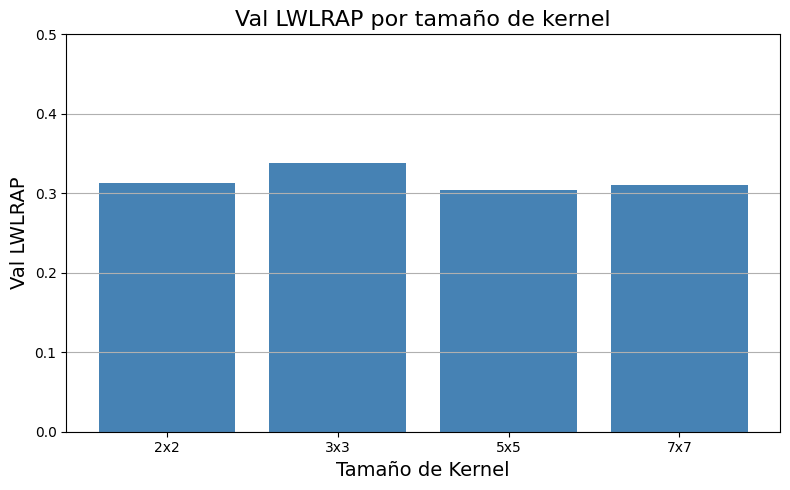

In [127]:
import matplotlib.pyplot as plt

# Separar los valores
kernel_labels = [f"{ks[0]}x{ks[1]}" for ks, _ in resultados]
val_scores = [score for _, score in resultados]

# Graficar
plt.figure(figsize=(8, 5))
plt.bar(kernel_labels, val_scores, color='steelblue')
plt.title('Val LWLRAP por tamaño de kernel', fontsize=16)
plt.xlabel('Tamaño de Kernel', fontsize=14)
plt.ylabel('Val LWLRAP', fontsize=14)
plt.ylim(0, 0.5)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()